# Stock Fluctuations

<div style="text-align: right"> Author: Vassil Dimitrov </div>
<div style="text-align: right"> Date: 2023-07-30 </div>

## Prep

In [1]:
import numpy as np
import pandas as pd

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

---

## Read data

In [4]:
dat = pd.read_csv('stocks_data_tsv.txt', sep='\t', header=0, index_col=False)
display(dat.head())

date  year  month  week  day    lose perc_change upper   lower  \
0   1/8/2018  2018      1     2    8  $15.96       2.30%    5%  -5.00%   
1  1/10/2018  2018      1     2   10  $13.20       2.80%    5%  -5.00%   
2  1/11/2018  2018      1     2   11  $10.67       1.00%    5%  -5.00%   
3   2/8/2018  2018      2     6    8  $15.48      -2.30%    5%  -5.00%   
4  2/10/2018  2018      2     6   10  $12.72      -2.80%    5%  -5.00%   

   volume    open      hi      lo  
0   50387  $15.60  $15.96  $15.24  
1   69478  $12.84  $13.44  $12.72  
2   77944  $10.56  $10.80  $10.08  
3   65154  $15.84  $15.84  $15.30  
4   75752  $13.08  $13.08  $12.72

---

## Tidy up data

### Column Names and Types

#### Names

First, drop all white spaces from dataframe names.

In [11]:
dat.rename(columns = lambda x: x.strip(), inplace=True)
# Sanity check:
print(dat.columns)

Index(['date', 'year', 'month', 'week', 'day', 'lose', 'perc_change', 'upper',
       'lower', 'volume', 'open', 'hi', 'lo'],
      dtype='object')


In [14]:
dat.rename(columns={'lose': 'close'}, inplace=True)

#### Types

Check the type for each column.

In [15]:
print(dat.dtypes)

date           object
year            int64
month           int64
week            int64
day             int64
close          object
perc_change    object
upper          object
lower          object
volume          int64
open           object
hi             object
lo             object
dtype: object


All the object variables have to be converted to numeric. Most of them are in fact already numeric, but were read in as strings duet to the presence of special characters.

In [16]:
display(dat.head(5))

date  year  month  week  day   close perc_change upper   lower  \
0   1/8/2018  2018      1     2    8  $15.96       2.30%    5%  -5.00%   
1  1/10/2018  2018      1     2   10  $13.20       2.80%    5%  -5.00%   
2  1/11/2018  2018      1     2   11  $10.67       1.00%    5%  -5.00%   
3   2/8/2018  2018      2     6    8  $15.48      -2.30%    5%  -5.00%   
4  2/10/2018  2018      2     6   10  $12.72      -2.80%    5%  -5.00%   

   volume    open      hi      lo  
0   50387  $15.60  $15.96  $15.24  
1   69478  $12.84  $13.44  $12.72  
2   77944  $10.56  $10.80  $10.08  
3   65154  $15.84  $15.84  $15.30  
4   75752  $13.08  $13.08  $12.72

##### `date`

First, convert `date` to *datetime* format.

In [ ]:
# Convert to datetime
dat['date'] = pd.to_datetime(dat['date'], format='%m/%d/%Y')
# Sanity check
print(dat.head()['date'])

`year`, `month`, `week` and `day`

These variables are in *int64* format. However, these are small integers that are always positive and so can be converted to a  more efficient format to save space.

In [25]:
print('Maximum values for:\n-----------')
print('year: ', dat['year'].max())
print('month: ', dat['month'].max())
print('week: ', dat['week'].max())
print('day: ', dat['day'].max())

Maximum values for:
-----------
year:  2023
month:  12
week:  53
day:  31


While `year` has to be of *uint32*, `month`, `week`, and `day` can have *uin8* format as they are positives less than 255.

In [26]:
dat['year'] = dat['year'].astype('uint32')
dat[['month', 'week', 'day']] = dat[['month', 'week', 'day']].astype("uint8")
# Sanity check:
dat.dtypes

##### `close`, `open`, `hi` and `lo`

For these 4 variables, remove `$` and check max and min values to assign appropriate type.

In [35]:
# Remove $ sign
for col in list(['close', 'open', 'hi', 'lo']):
    print(f'Converting "{col}"...')
    dat[col] = dat[col].str.replace('$', '')
# Sanity check:
display(dat.head())

Converting "close"...
Converting "open"...
Converting "hi"...
Converting "lo"...


C:\Users\Admin\AppData\Local\Temp\ipykernel_10980\4083047082.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dat[col] = dat[col].str.replace('$', '')


date  year  month  week  day  close perc_change upper   lower  volume  \
0 2018-01-08  2018      1     2    8  15.96       2.30%    5%  -5.00%   50387   
1 2018-01-10  2018      1     2   10  13.20       2.80%    5%  -5.00%   69478   
2 2018-01-11  2018      1     2   11  10.67       1.00%    5%  -5.00%   77944   
3 2018-02-08  2018      2     6    8  15.48      -2.30%    5%  -5.00%   65154   
4 2018-02-10  2018      2     6   10  12.72      -2.80%    5%  -5.00%   75752   

    open     hi     lo  
0  15.60  15.96  15.24  
1  12.84  13.44  12.72  
2  10.56  10.80  10.08  
3  15.84  15.84  15.30  
4  13.08  13.08  12.72

Now check what the maximum and minimum values for each of these columns are in order to be able to assign the appropriate data type.

In [37]:
# Remove $ sign
for col in list(['close', 'open', 'hi', 'lo']):
    print(f'Type of "{col}"...', dat[col].dtype)
# Convert to number:
for col in list(['close', 'open', 'hi', 'lo']):
    print(f'Converting "{col}" to float...')
    dat[col] = dat[col].astype('float')

Type of "close"... object
Type of "open"... object
Type of "hi"... object
Type of "lo"... object
Converting "close" to float...
Converting "open" to float...
Converting "hi" to float...
Converting "lo" to float...


In [40]:
# Check max and min values:
for col in list(['close', 'open', 'hi', 'lo']):
    print(f'Max of "{col}":', dat[col].max())
    print(f'Min of "{col}":', dat[col].min())

Max of "close": 27.96
Min of "close": 0.16
Max of "open": 29.2
Min of "open": 0.16
Max of "hi": 29.44
Min of "hi": 0.19
Max of "lo": 26.81
Min of "lo": 0.13


Note that all of the values are positive floats and less than 255. Therefore, they will be converted to type *float32*, which will provide good enough accuracy.

In [42]:
# Convert to float32 type
for col in list(['close', 'open', 'hi', 'lo']):
    dat[col]= dat[col].astype('float32')

##### `upper` and `lower`

Same procedure as above. First, remove the `%` sign and then find out the max and min values to understand to what type to convert the data.

In [43]:
# Remove $ sign
for col in list(['perc_change', 'upper', 'lower']):
    print(f'Converting "{col}"...')
    dat[col] = dat[col].str.replace('%', '')
# Sanity check:
display(dat.head())

Converting "perc_change"...
Converting "upper"...
Converting "lower"...


date  year  month  week  day  close perc_change upper  lower  volume  \
0 2018-01-08  2018      1     2    8  15.96        2.30     5  -5.00   50387   
1 2018-01-10  2018      1     2   10  13.20        2.80     5  -5.00   69478   
2 2018-01-11  2018      1     2   11  10.67        1.00     5  -5.00   77944   
3 2018-02-08  2018      2     6    8  15.48       -2.30     5  -5.00   65154   
4 2018-02-10  2018      2     6   10  12.72       -2.80     5  -5.00   75752   

    open     hi     lo  
0  15.60  15.96  15.24  
1  12.84  13.44  12.72  
2  10.56  10.80  10.08  
3  15.84  15.84  15.30  
4  13.08  13.08  12.72

In [44]:
# Remove $ sign
for col in list(['perc_change', 'upper', 'lower']):
    print(f'Converting "{col}"...')
    dat[col] = dat[col].astype('float')

Converting "perc_change"...
Converting "upper"...
Converting "lower"...


In [45]:
# Check for max and min values
for col in list(['perc_change', 'upper', 'lower']):
    print(f'Max "{col}":', dat[col].max())
    print(f'Min "{col}":', dat[col].min())

Max "perc_change": 71.9
Min "perc_change": -35.4
Max "upper": 5.0
Min "upper": 5.0
Max "lower": -5.0
Min "lower": -5.0


*float32* will be more than adequate to represent the data.

In [47]:
# Convert to float 32
for col in list(['perc_change', 'upper', 'lower']):
    dat[col] = dat[col].astype('float32')

In [48]:
# Sanity check:
display(dat.head())

date  year  month  week  day  close  perc_change  upper  lower  \
0 2018-01-08  2018      1     2    8  15.96          2.3    5.0   -5.0   
1 2018-01-10  2018      1     2   10  13.20          2.8    5.0   -5.0   
2 2018-01-11  2018      1     2   11  10.67          1.0    5.0   -5.0   
3 2018-02-08  2018      2     6    8  15.48         -2.3    5.0   -5.0   
4 2018-02-10  2018      2     6   10  12.72         -2.8    5.0   -5.0   

   volume   open     hi     lo  
0   50387  15.60  15.96  15.24  
1   69478  12.84  13.44  12.72  
2   77944  10.56  10.80  10.08  
3   65154  15.84  15.84  15.30  
4   75752  13.08  13.08  12.72

In [50]:
print(dat.dtypes)

date           datetime64[ns]
year                   uint32
month                   uint8
week                    uint8
day                     uint8
close                 float32
perc_change           float32
upper                 float32
lower                 float32
volume                  int64
open                  float32
hi                    float32
lo                    float32
dtype: object


At this point, all data types are numeric.

### Null values

Find out whether there are null values.

In [51]:
print(dat.isna().sum())

date           0
year           0
month          0
week           0
day            0
close          0
perc_change    0
upper          0
lower          0
volume         0
open           0
hi             0
lo             0
dtype: int64


No null values, so we can proceeed.

### Duplications

In [52]:
# Dimensions of table.
print('Current table dimensions:', dat.shape)
# Remove duplicated rows
dat.drop_duplicates(inplace=True)
# Check result
print('Table dimensions after removing duplicates:', dat.shape)

Current table dimensions: (1225, 13)
Table dimensions after removing duplicates: (1225, 13)


No duplicated rows.

Save table for future analysis.

In [53]:
dat.to_pickle('dat.pkl')

---

## Exploratory Data Analysis

Load pickled data.

In [2]:
df = pd.read_pickle ('dat.pkl')

In [3]:
# Sanity check:
print('Dimensions:', df.shape)

Dimensions: (1225, 13)


In [4]:
df.set_index('date', inplace=True)

In [5]:
# Remove upper and lower bounds
df.drop(columns=['upper','lower'], inplace=True)

### Correlation

Look for correlations among the different variables.

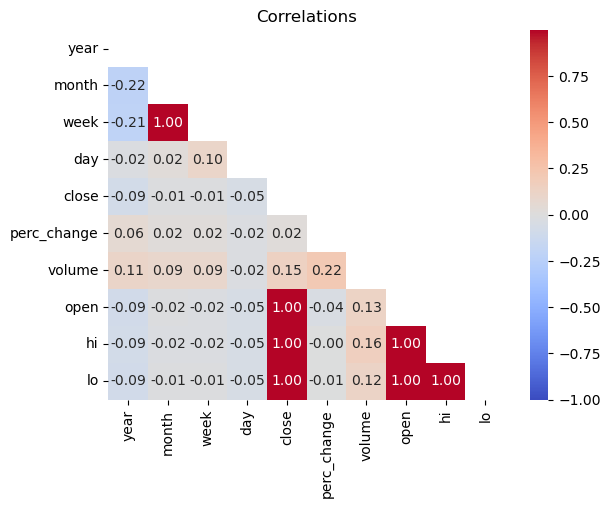

In [11]:
# Calculate correlation
corr_matrix = df.corr()
# Create a mask for upper triangle (including diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# Create a heatmap for variable correlation
plt.figure()
sns.heatmap(corr_matrix, 
            annot=True,
            mask=mask,
            cmap='coolwarm', fmt='.2f', vmin=-1)
plt.title('Correlations')
plt.show()

As expected, the value at closing is perfectly correlated with values at open, with high and low values throughout the day. There is also a positive correlation between percent change and the total volume traded, as expected. The remaining correlations are quite small (insignificant).  

### Values vs Time

Let us explore how the values at open and close fluctuate with time.

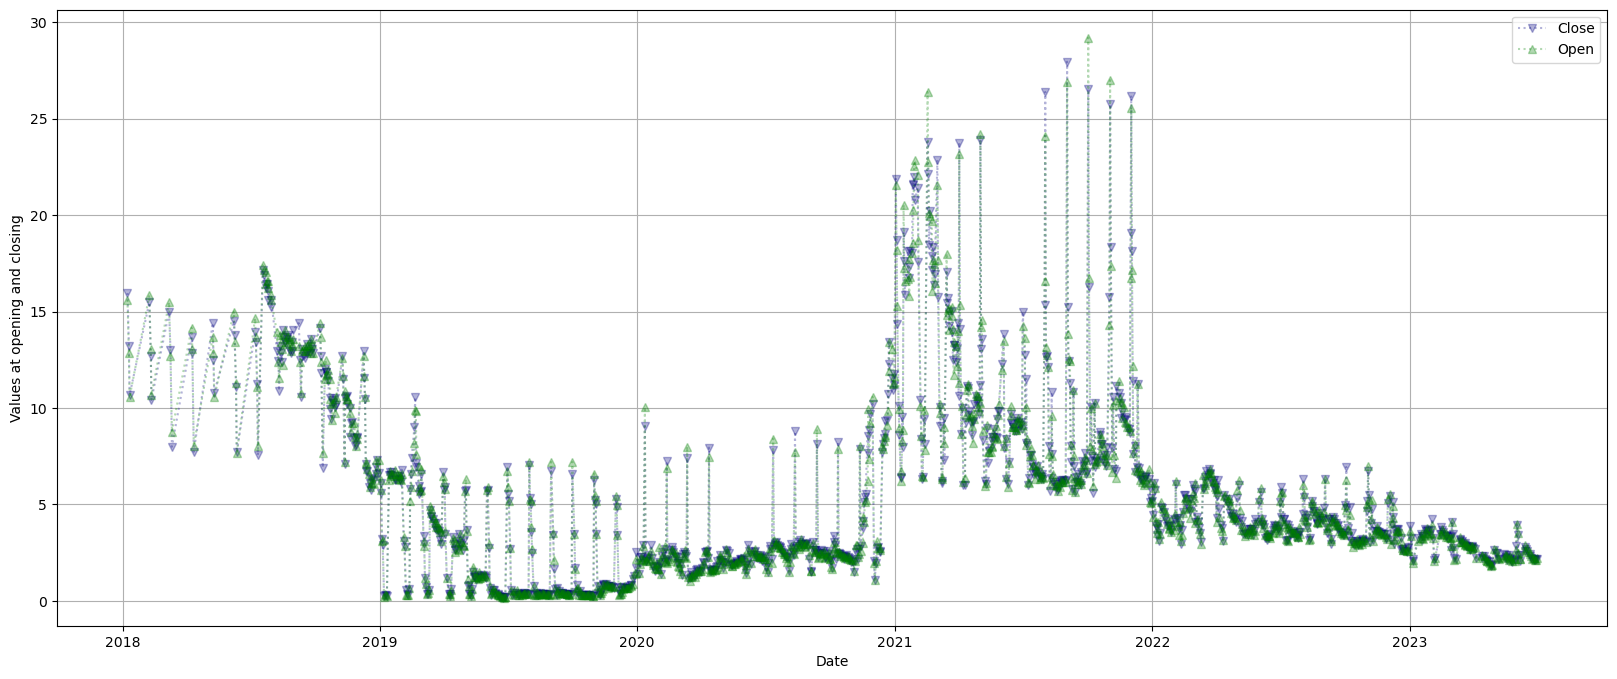

In [14]:
plt.figure(figsize=(20, 8))
plt.plot(df.index, df['close'], label='Close', marker='v', color='navy', alpha=0.3, linestyle=':')
plt.plot(df.index, df['open'], label='Open', marker='^', color='green', alpha=0.3, linestyle=':')
plt.xlabel('Date')
plt.ylabel('Values at opening and closing')
plt.legend()
plt.grid(True)
plt.show()

It is very clear that the stocks go down for 2 consecutive days and then jump up for the third timepoint.  
  Zoom in on 2023 only.

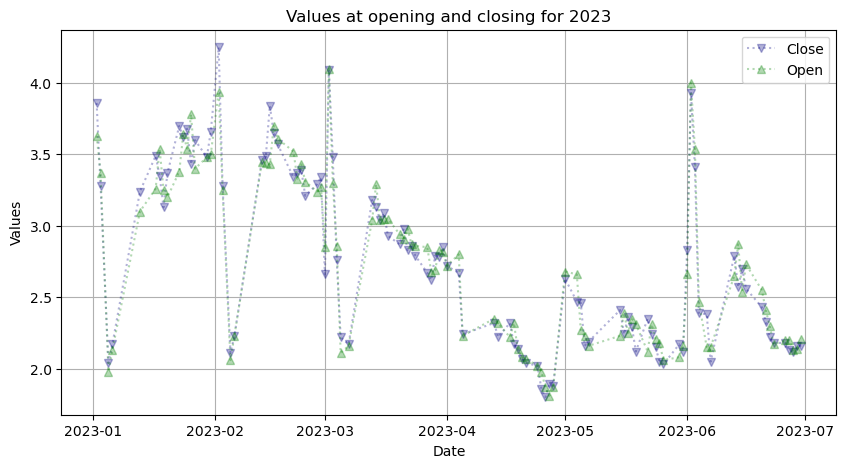

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(df[df['year']==2023].index, df[df['year']==2023]['close'], 
         label='Close', marker='v', color='navy', alpha=0.3, linestyle=':')
plt.plot(df[df['year']==2023].index, df[df['year']==2023]['open'], 
         label='Open', marker='^', color='green', alpha=0.3, linestyle=':')
plt.xlabel('Date')
plt.title('Values at opening and closing for 2023')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

### Modulate the date window

In [6]:
# add lines for each column
fig = px.line(df, 
              x=df.index, 
              y=df[['open','close']].columns)

# axis labels and title
fig.update_layout(
    yaxis_title="Value", 
    legend_title="", 
    title="Stock value at opening and closing"
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

### Distributions

Plot the variable distributions for each feature.

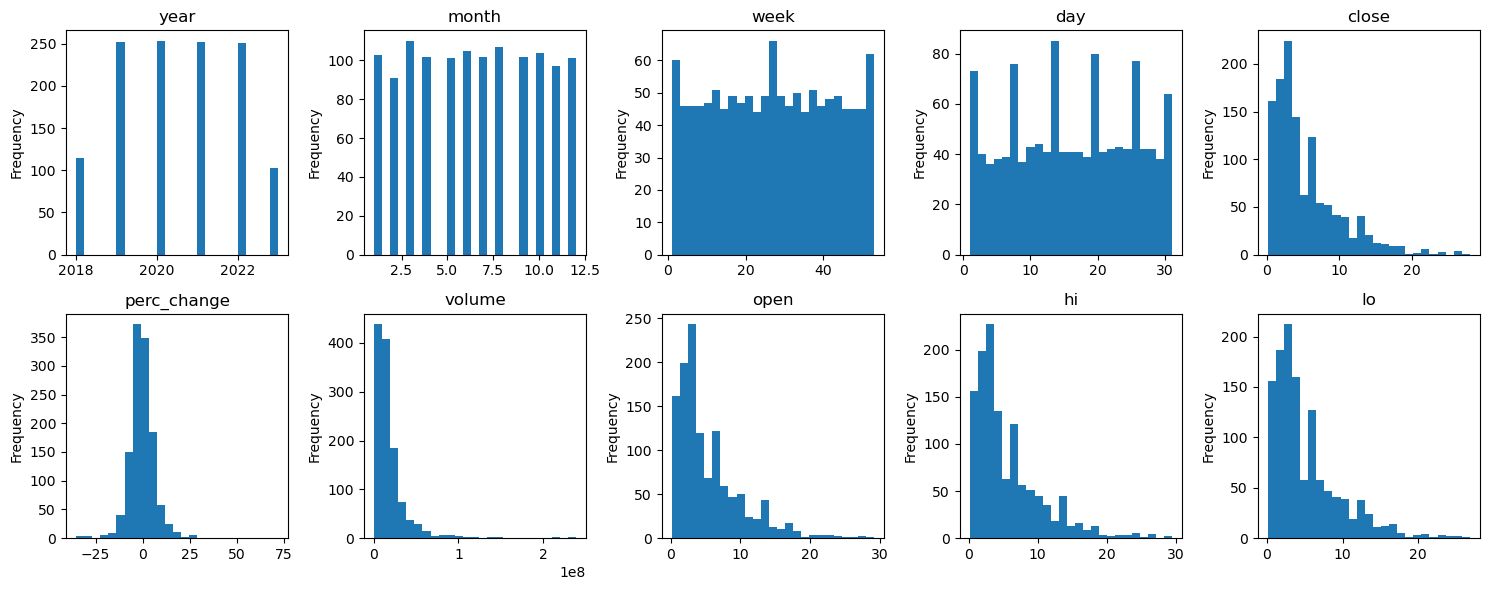

In [29]:
# Plot the distribution of all features as histograms
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i, col in enumerate(df.columns):
    df[col].plot(kind='hist', bins=25, ax=axes[i//5, i%5], title=col)

plt.tight_layout()
plt.show()

`perc_change` is centered around 0 (overall no change) and is fairly normally distributed. `volume`, `close`, `open`, `hi` and `lo`, on the other hand are right-skewed. These values can be transformed by taking their log. This will make them more normally distributed, which will be helpful for linear regression. 

Look at the following:
- correlation heatmap
- percent change as a function of time
- variable distribution (histogram) with mean and median

In [4]:
df.set_index('date', inplace=True)
display(df.head())

year  month  week  day  close  perc_change  upper  lower  volume  \
date                                                                           
2018-01-08  2018      1     2    8  15.96          2.3    5.0   -5.0   50387   
2018-01-10  2018      1     2   10  13.20          2.8    5.0   -5.0   69478   
2018-01-11  2018      1     2   11  10.67          1.0    5.0   -5.0   77944   
2018-02-08  2018      2     6    8  15.48         -2.3    5.0   -5.0   65154   
2018-02-10  2018      2     6   10  12.72         -2.8    5.0   -5.0   75752   

             open     hi     lo  
date                             
2018-01-08  15.60  15.96  15.24  
2018-01-10  12.84  13.44  12.72  
2018-01-11  10.56  10.80  10.08  
2018-02-08  15.84  15.84  15.30  
2018-02-10  13.08  13.08  12.72